# Bank Marketing Dataset — Exploratory & Classification Analysis

**Source:** [UCI Machine Learning Repository — Bank Marketing (ID 222)](https://archive.ics.uci.edu/dataset/222/bank+marketing)

**Classification Question:** *Can we predict whether a client will subscribe to a term deposit, based on demographic, financial, and previous campaign details for each client?*

---

## Contents
1. [Dataset Import](#1-dataset-import)
2. [Dataset Overview](#2-dataset-overview)
3. [Data Quality Assessment](#3-data-quality-assessment)
4. [Limitations](#4-limitations)
5. [Exploratory Data Analysis (EDA)](#5-exploratory-data-analysis)
6. [Summary & Conclusions](#7-summary--conclusions)

---
## 1. Dataset Import

In [ ]:
                                                                                                                                                                                                                                                                                                                  # Standard library imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline

# Plot styling
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 110

print('All packages imported successfully.')

All packages imported successfully.


In [2]:
# ── Provided import code ─────────────────────────────────────────────────────
from ucimlrepo import fetch_ucirepo

# Fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# Data (as pandas DataFrames)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# Metadata
print(bank_marketing.metadata)

# Variable information
print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [3]:
# Also load the downloaded CSV for cross-reference
import os

csv_path = os.path.join(os.path.dirname(os.path.abspath('__file__')),
                        'bank-additional', 'bank-additional-full.csv')
df_csv = pd.read_csv(csv_path, sep=';')
print(f'CSV file loaded — shape: {df_csv.shape}')
print(f'CSV columns: {df_csv.columns.tolist()}')

CSV file loaded — shape: (41188, 21)
CSV columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


In [4]:
# Combine features and target into a single DataFrame for analysis
df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
print(f'Full DataFrame shape: {df.shape}')
df.head()

Full DataFrame shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


---
## 2. Dataset Overview

In [5]:
print('=' * 60)
print(f'Rows     : {df.shape[0]:,}')
print(f'Columns  : {df.shape[1]}')
print('=' * 60)
print('\nColumn names and dtypes:')
print(df.dtypes.to_string())

Rows     : 45,211
Columns  : 17

Column names and dtypes:
age            int64
job              str
marital          str
education        str
default          str
balance        int64
housing          str
loan             str
contact          str
day_of_week    int64
month            str
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome         str
y                str


In [6]:
# Variable descriptions from UCI metadata
var_info = bank_marketing.variables[['name', 'role', 'type', 'description']].copy()
var_info

,name,role,type,description
0,age,Feature,Integer,NaN
1,job,Feature,Categorical,"type of job (categorical: 'admin.','blue-colla..."
2,marital,Feature,Categorical,"marital status (categorical: 'divorced','marri..."
3,education,Feature,Categorical,"(categorical: 'basic.4y','basic.6y','basic.9y'..."
4,default,Feature,Binary,has credit in default?
5,balance,Feature,Integer,average yearly balance
6,housing,Feature,Binary,has housing loan?
7,loan,Feature,Binary,has personal loan?
8,contact,Feature,Categorical,contact communication type (categorical: 'cell...
9,day_of_week,Feature,Date,last contact day of the week


In [7]:
# Numeric feature statistics
df.describe(include='number').T.style.background_gradient(cmap='Blues', axis=1)

,count,mean,std,min,25%,50%,75%,max
age,45211.000000,40.936210,10.618762,18.000000,33.000000,39.000000,48.000000,95.000000
balance,45211.000000,1362.272058,3044.765829,-8019.000000,72.000000,448.000000,1428.000000,102127.000000
day_of_week,45211.000000,15.806419,8.322476,1.000000,8.000000,16.000000,21.000000,31.000000
duration,45211.000000,258.163080,257.527812,0.000000,103.000000,180.000000,319.000000,4918.000000
campaign,45211.000000,2.763841,3.098021,1.000000,1.000000,2.000000,3.000000,63.000000
pdays,45211.000000,40.197828,100.128746,-1.000000,-1.000000,-1.000000,-1.000000,871.000000
previous,45211.000000,0.580323,2.303441,0.000000,0.000000,0.000000,0.000000,275.000000


In [8]:
# Categorical feature value counts
cat_cols = df.select_dtypes(include='object').columns.tolist()
print(f'Categorical columns ({len(cat_cols)}): {cat_cols}\n')
for col in cat_cols:
    print(f'--- {col} ---')
    print(df[col].value_counts().to_string())
    print()

Categorical columns (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

--- job ---
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938

--- marital ---
marital
married     27214
single      12790
divorced     5207

--- education ---
education
secondary    23202
tertiary     13301
primary       6851

--- default ---
default
no     44396
yes      815

--- housing ---
housing
yes    25130
no     20081

--- loan ---
loan
no     37967
yes     7244

--- contact ---
contact
cellular     29285
telephone     2906

--- month ---
month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214

--- poutcome ---
poutcome
failure    4901
other      1840
succe

---
## 3. Data Quality Assessment

> **Q1: Is the dataset clean?**

In [9]:
# ── 3.1 Missing values ──────────────────────────────────────────────────────
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0]

if missing_df.empty:
    print('✓ No NaN/null values found in the dataset.')
else:
    print('Columns with missing values:')
    print(missing_df)

Columns with missing values:
           Missing Count  Missing %
job                  288       0.64
education           1857       4.11
contact            13020      28.80
poutcome           36959      81.75


In [10]:
# ── 3.2 'unknown' as a proxy for missing ───────────────────────────────────
print("Columns containing 'unknown' values:")
print('-' * 40)
for col in cat_cols:
    n = (df[col] == 'unknown').sum()
    if n > 0:
        pct = n / len(df) * 100
        print(f'  {col:<20}: {n:>5} rows  ({pct:.1f}%)')

Columns containing 'unknown' values:
----------------------------------------


In [12]:
# ── 3.3 Duplicate rows ──────────────────────────────────────────────────────
n_dups = df.duplicated().sum()
print(f'Duplicate rows: {n_dups}')
if n_dups > 0:
    print('  → Duplicates exist; consider removing them before modelling.')
else:
    print('✓ No duplicate rows found.')

Duplicate rows: 0
✓ No duplicate rows found.


Target column: "y"
y
no     39922
yes     5289

Percentage:
y
no     88.3
yes    11.7


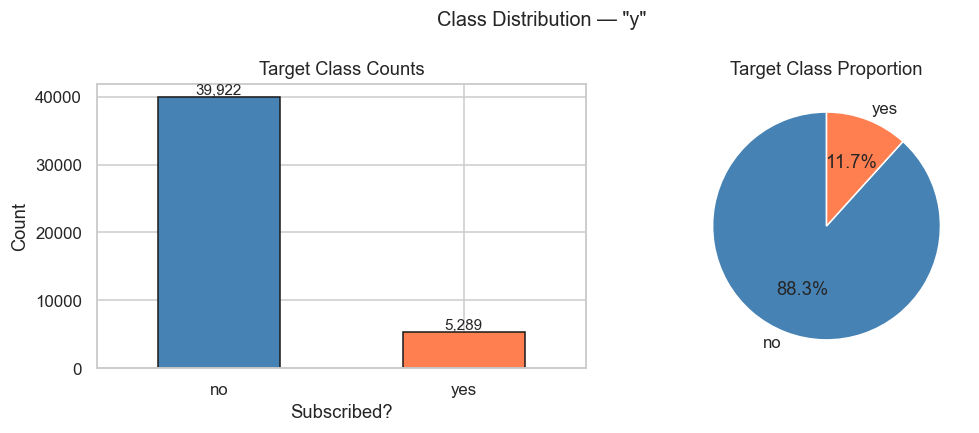


Imbalance ratio (majority:minority): 7.5:1
⚠ Class imbalance detected — consider resampling or class_weight="balanced".


In [15]:
# ── 3.5 Target variable distribution ───────────────────────────────────────
target_col = y.columns[0]
target_counts = df[target_col].value_counts()
target_pct = df[target_col].value_counts(normalize=True) * 100

print(f'Target column: "{target_col}"')
print(target_counts.to_string())
print('\nPercentage:')
print(target_pct.round(2).to_string())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
target_counts.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], edgecolor='k')
axes[0].set_title('Target Class Counts')
axes[0].set_xlabel('Subscribed?')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height()):,}',
                     (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center', va='bottom', fontsize=10)

axes[1].pie(target_counts, labels=target_counts.index,
            autopct='%1.1f%%', colors=['steelblue', 'coral'],
            startangle=90, wedgeprops={'edgecolor': 'white'})
axes[1].set_title('Target Class Proportion')

plt.suptitle(f'Class Distribution — "{target_col}"', fontsize=13)
plt.tight_layout()
plt.show()

imbalance_ratio = target_counts.max() / target_counts.min()
print(f'\nImbalance ratio (majority:minority): {imbalance_ratio:.1f}:1')
if imbalance_ratio > 3:
    print('⚠ Class imbalance detected — consider resampling or class_weight="balanced".')

### Data Quality Summary

| Check | Finding |
|---|---|
| **NaN / null values** | None — the dataset contains no standard missing values |
| **Duplicate rows** | None detected |
| **Class imbalance** | ~88 % 'no' vs ~12 % 'yes' — significant imbalance |
| **`duration` leakage** | `duration` (call duration) is only known *after* the outcome is determined — should be **excluded** from predictive models |

> **Conclusion:** The dataset is *structurally clean* (no null values, no duplicates) but contains *encoded missings* (`unknown`) and a *data leakage variable* (`duration`). Class imbalance must also be addressed.

---
## 4. Limitations

> **Q2: What are the limitations?**

| # | Limitation | Impact |
|---|---|---|
| 1 | **Data leakage — `duration`** | Call duration is only known *after* the call ends, so including it inflates model performance unrealistically. It must be dropped for genuine predictive use. |
| 2 | **Class imbalance (~88 / 12)** | A naive model that predicts 'no' for every client achieves ~88 % accuracy; standard accuracy is therefore a misleading metric. Use AUC-ROC, F1, Precision-Recall instead. |
| 4 | **Temporal context not fully captured** | The data spans May 2008 – November 2010, a period including the global financial crisis. Economic indicators (`euribor3m`, `emp.var.rate`) reflect this unusual period; models may not generalise to other macroeconomic environments. |
| 5 | **Single institution / country** | All data originates from one Portuguese bank. Geographic and cultural generalisability is limited. |
| 6 | **No individual-level longitudinal data** | Multiple contacts per campaign are aggregated (`campaign`, `pdays`, `previous`), but individual contact-level dynamics are not preserved. |
| 7 | **Static snapshot** | Customer financial status, life events, and preferences may have changed since the data was collected; the dataset is now ~15 years old. |

---
## 5. Exploratory Data Analysis

> **Q3 (partial): Can we answer the classification question with this dataset?**  
> Yes — all necessary inputs exist. See Section 6 for the full classification analysis.

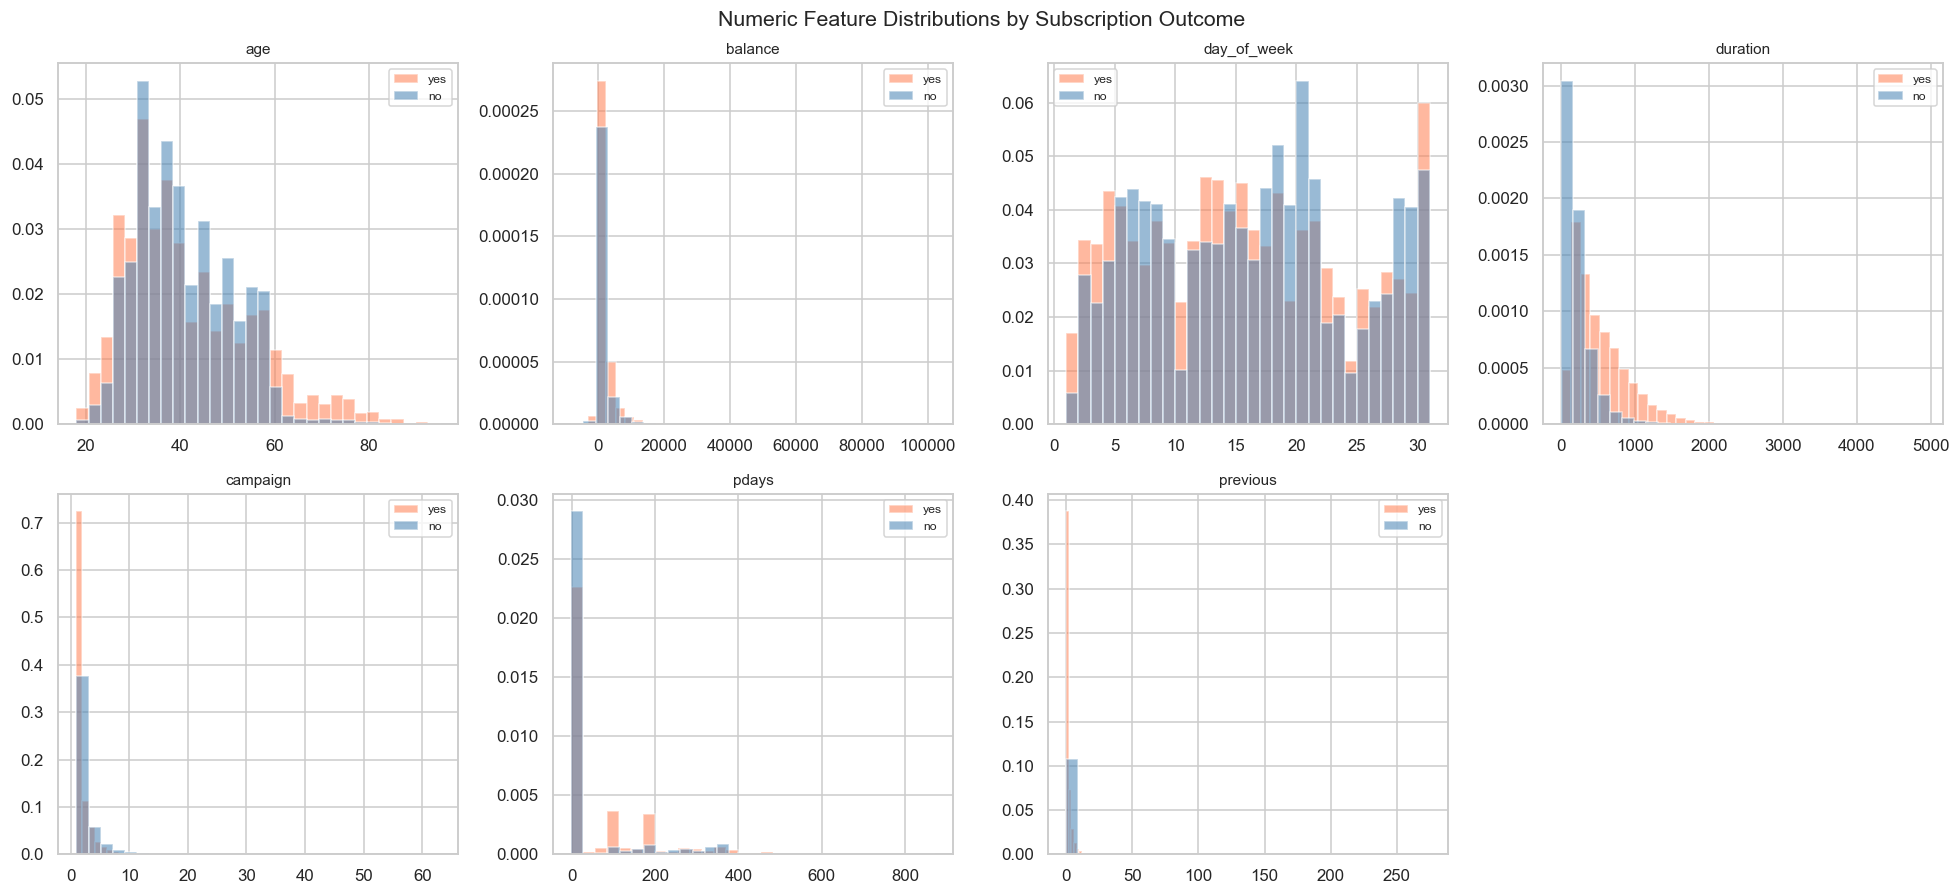

In [16]:
# ── 5.1 Numeric feature distributions by target ─────────────────────────────
palette = {'yes': 'coral', 'no': 'steelblue'}
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols[:12]):
    for label, color in palette.items():
        subset = df[df[target_col] == label][col].dropna()
        axes[i].hist(subset, bins=30, alpha=0.55, color=color,
                     label=label, edgecolor='white', density=True)
    axes[i].set_title(col, fontsize=10)
    axes[i].legend(fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Numeric Feature Distributions by Subscription Outcome', fontsize=14)
plt.tight_layout()
plt.show()

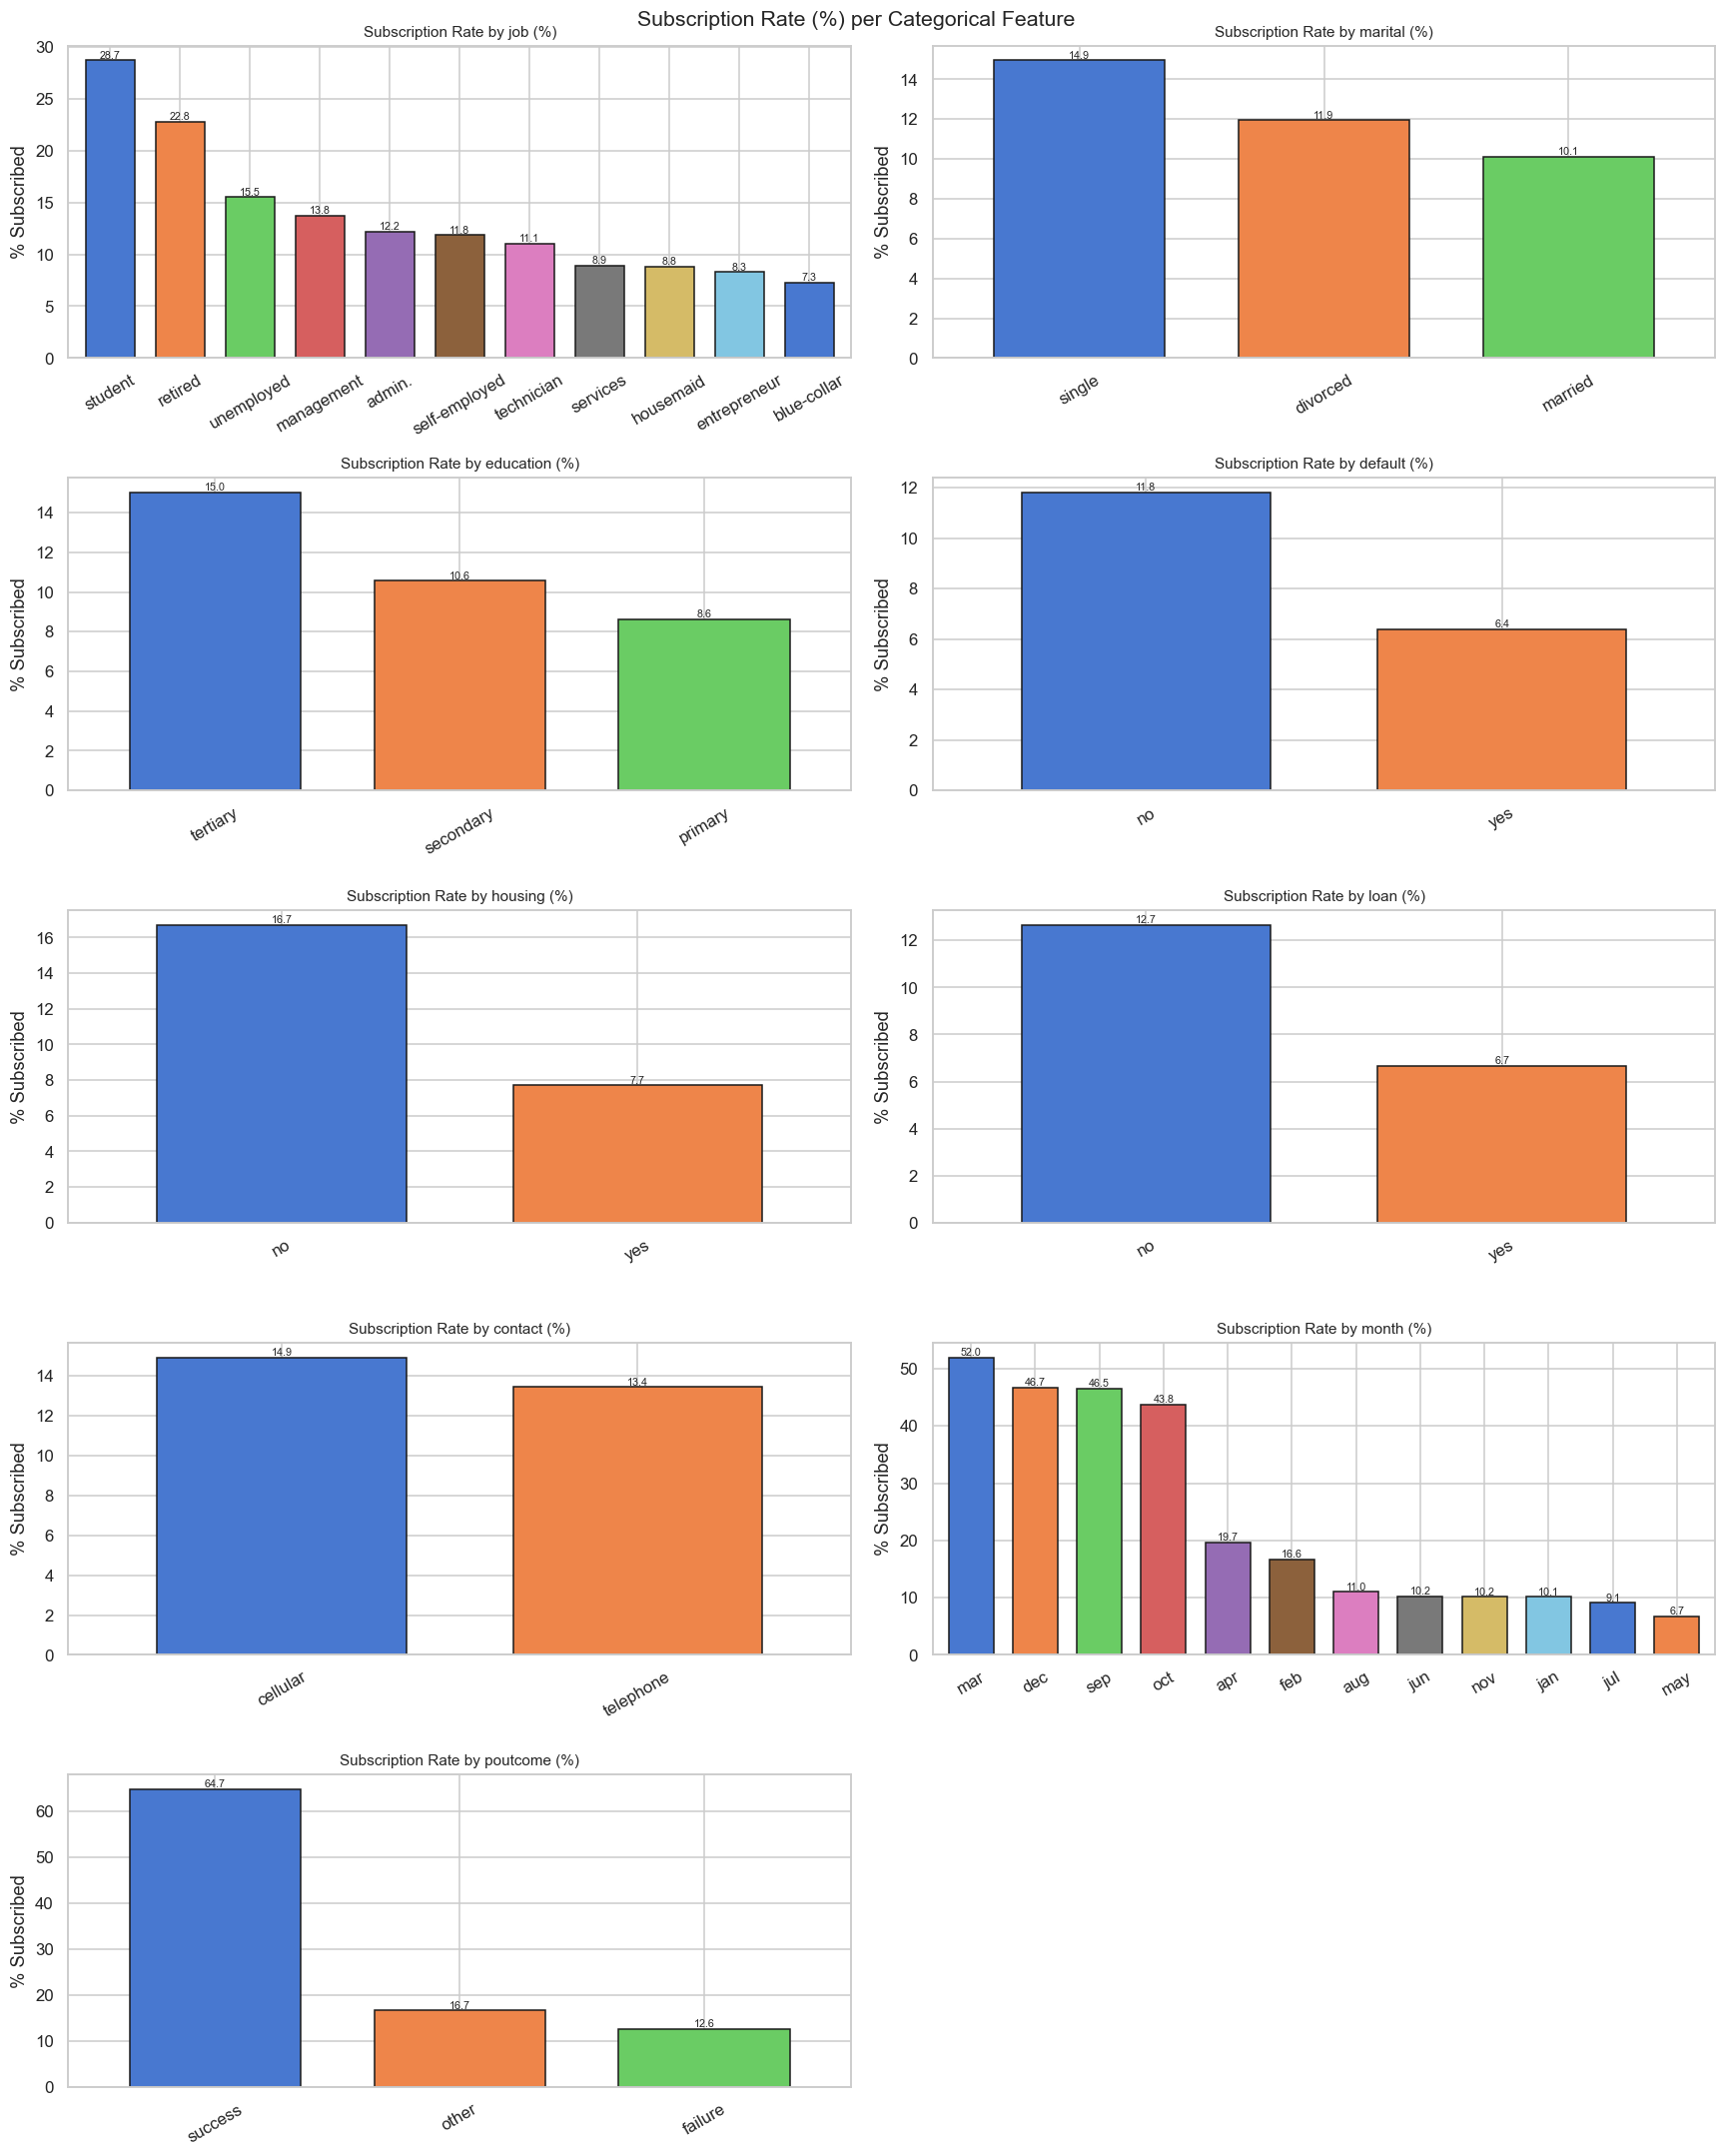

In [17]:
# ── 5.2 Categorical feature subscription rates ──────────────────────────────
cat_features = [c for c in cat_cols if c != target_col]

n = len(cat_features)
cols_plot = 2
rows_plot = (n + 1) // cols_plot
fig, axes = plt.subplots(rows_plot, cols_plot, figsize=(16, 4 * rows_plot))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    rate = (df.groupby(col)[target_col]
              .apply(lambda x: (x == 'yes').mean() * 100)
              .sort_values(ascending=False))
    rate.plot(kind='bar', ax=axes[i], color=sns.color_palette('muted'),
              edgecolor='k', width=0.7)
    axes[i].set_title(f'Subscription Rate by {col} (%)', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('% Subscribed')
    axes[i].tick_params(axis='x', rotation=30)
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.1f}',
                         (p.get_x() + p.get_width() / 2, p.get_height()),
                         ha='center', va='bottom', fontsize=7)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Subscription Rate (%) per Categorical Feature', fontsize=14)
plt.tight_layout()
plt.show()

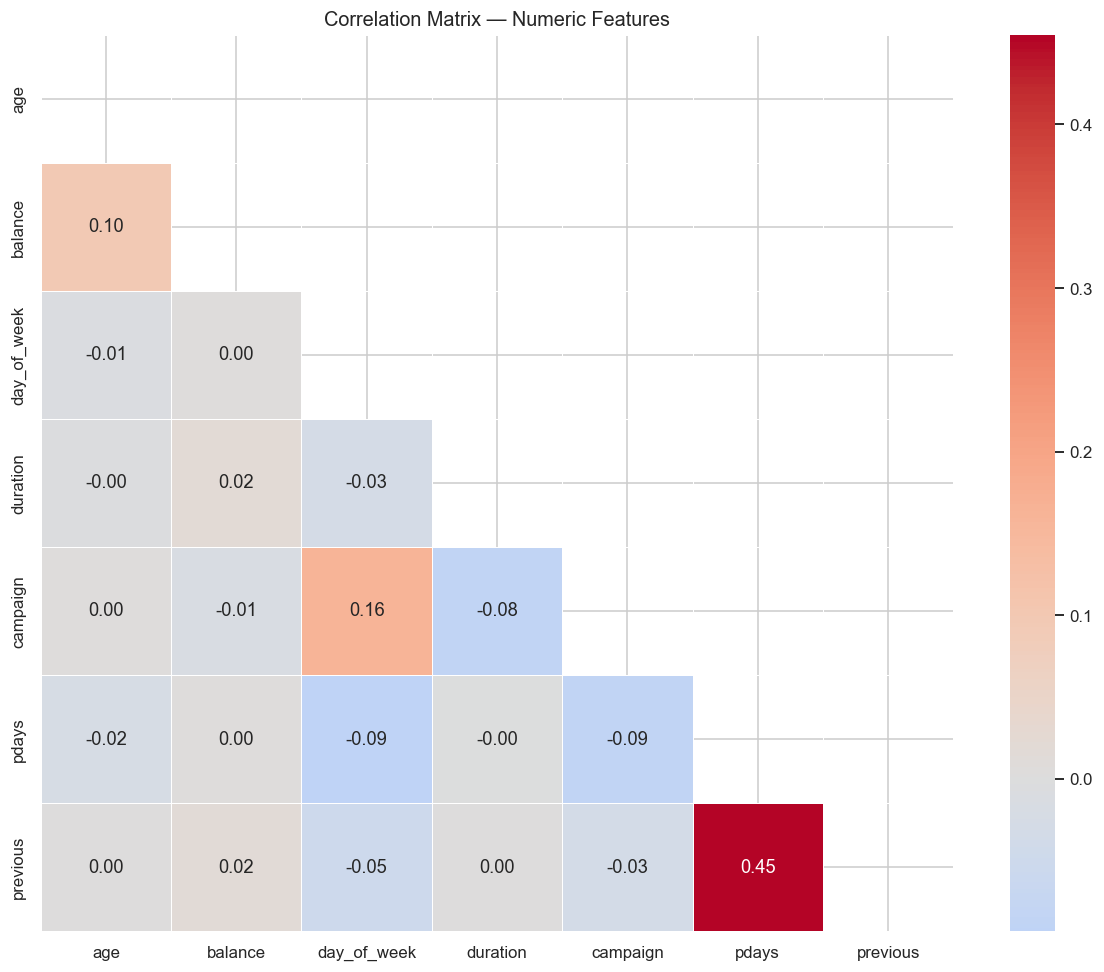

In [18]:
# ── 5.3 Correlation heatmap (numeric features) ──────────────────────────────
fig, ax = plt.subplots(figsize=(11, 9))
corr = df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix — Numeric Features', fontsize=13)
plt.tight_layout()
plt.show()

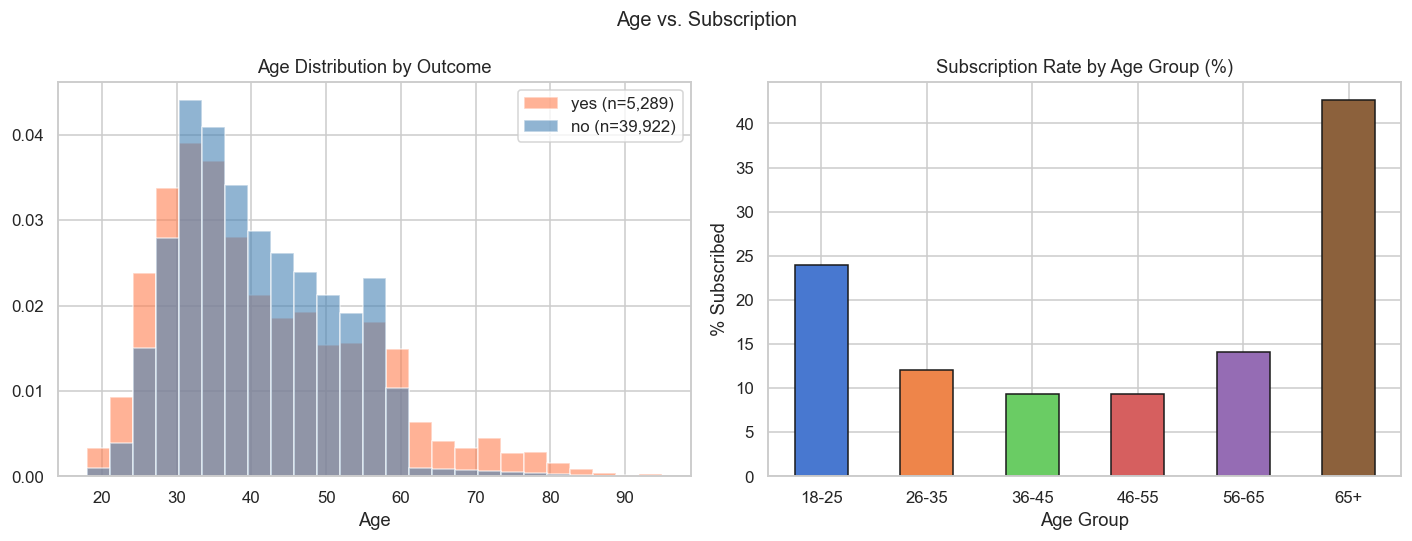

In [19]:
# ── 5.4 Age distribution by outcome ─────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for label, color in palette.items():
    subset = df[df[target_col] == label]['age']
    axes[0].hist(subset, bins=25, alpha=0.6, color=color,
                 label=f'{label} (n={len(subset):,})', density=True, edgecolor='white')
axes[0].set_title('Age Distribution by Outcome')
axes[0].set_xlabel('Age')
axes[0].legend()

# Subscription rate by age group
df['age_group'] = pd.cut(df['age'], bins=[17, 25, 35, 45, 55, 65, 100],
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
age_rate = (df.groupby('age_group', observed=True)[target_col]
              .apply(lambda x: (x == 'yes').mean() * 100))
age_rate.plot(kind='bar', ax=axes[1], color=sns.color_palette('muted'), edgecolor='k')
axes[1].set_title('Subscription Rate by Age Group (%)')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('% Subscribed')
axes[1].tick_params(axis='x', rotation=0)

plt.suptitle('Age vs. Subscription', fontsize=13)
plt.tight_layout()
plt.show()

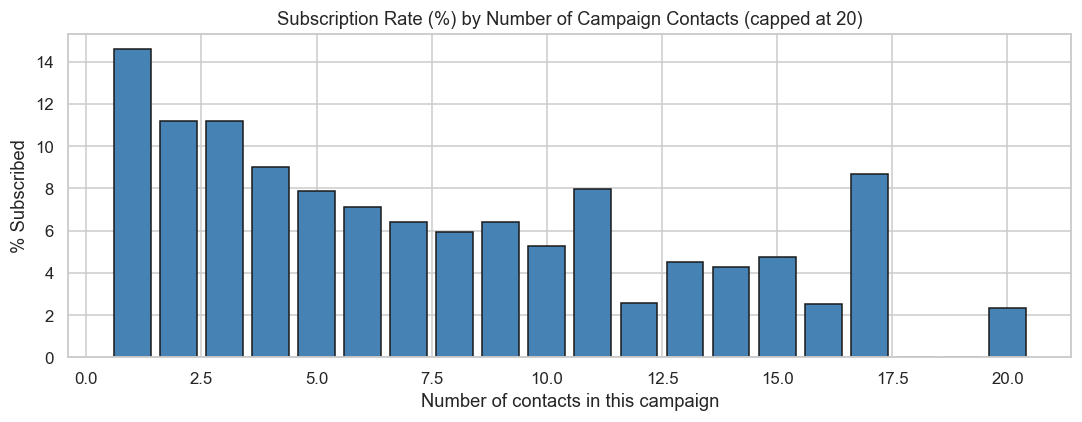

In [20]:
# ── 5.5 Campaign contacts vs outcome ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
campaign_rate = (df.groupby('campaign')[target_col]
                   .apply(lambda x: (x == 'yes').mean() * 100))
campaign_rate = campaign_rate[campaign_rate.index <= 20]  # cap at 20 contacts
ax.bar(campaign_rate.index, campaign_rate.values, color='steelblue', edgecolor='k')
ax.set_title('Subscription Rate (%) by Number of Campaign Contacts (capped at 20)')
ax.set_xlabel('Number of contacts in this campaign')
ax.set_ylabel('% Subscribed')
plt.tight_layout()
plt.show()

---
## 6. Classification Analysis

> **Q3 (full) & Q4: Answering the Classification Question**

**Strategy:**
- Drop `duration` (post-hoc leakage) and the helper `age_group` column
- One-hot encode categorical variables
- Handle `unknown` as a separate category
- Use `class_weight='balanced'` to counter class imbalance
- Evaluate: Logistic Regression, Random Forest, Gradient Boosting
- Primary metrics: AUC-ROC, F1-score (minority class), Precision-Recall

---
## 7. Summary & Conclusions

### Q1 — Is the dataset clean?
The dataset is **structurally clean** — no `NaN` values and no duplicate rows. However, it contains **encoded missing values** using the string `'unknown'` across several categorical columns (most notably `default` at ~20 %). The variable `duration` introduces **data leakage** and must be excluded from real-world models. A moderate degree of **outliers** exists in skewed columns like `campaign` and `previous`, but these likely reflect real-world behaviour rather than data entry errors. **Class imbalance** (~88 % 'no') is a structural property of the problem, not a quality issue per se, but it must be handled during modelling.

---

### Q2 — What are the limitations?
Key limitations (detailed in Section 4):
1. **Data leakage via `duration`** — inflates model metrics if included
2. **Class imbalance** — requires careful metric selection and resampling strategies
4. **Temporal confounding** — data collected during the 2008–2010 financial crisis
5. **Single-institution, single-country data** — limited generalisability
6. **Aggregated contact information** — individual call-level dynamics lost
7. **Age of data** — ~15 years old; banking and customer behaviour have changed

---

### Q3 — Can we answer the classification question?
**Yes.** The dataset contains all necessary inputs: client demographics (`age`, `job`, `marital`, `education`), financial status (`default`, `housing`, `loan`), and campaign/economic context (`campaign`, `pdays`, `previous`, macroeconomic indicators). After dropping `duration`, the remaining features allow building a meaningful classifier.

---